In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import copy
from scipy.integrate import odeint
s2h = 1/3600
h2s = 3600

/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# %% [Classes]
class RateConstant:
    def __init__(self, value=None, unit=None, ref=None, name=None, reaction_name=None):
        self.value = value
        self.unit = unit
        self.ref = ref
        self.name = name
        self.reaction_name = reaction_name

    def set_value(self, value):
        self.value = value
        return self
    def set_unit(self, unit):
        self.unit = unit
        return self
    def set_ref(self, ref):
        self.ref = ref
    def set_name(self, name):
        self.name = name
        return self
    def set_reaction_name(self, reaction_name):
        self.reaction_name = reaction_name
        return self
    def remove_value(self):
        self.value = None

class Species:
    def __init__(self, density=None, unit=None, name=None):
        self.density = density
        self.unit = unit
        self.name = name

    def set_density(self, density):
        self.density = density
        return self
    def set_unit(self, unit):
        self.unit = unit
        return self
    def set_name(self, name):
        self.name = name
        return self
    def remove_density(self):
        self.density = None
            

class Reaction: #general reactions
    reaction_type = 'genral reaction'
    
    def __init__(self,  
                 rate_constant=RateConstant(), 
                 reactants=(), 
                 products=(),  
                 name=None):
        self.rate_constant = rate_constant
        self.reactants = reactants
        self.products = products
        self.name = name

    def set_rate_constant(self, rate_constant):
        self.rate_constant = rate_constant
        return self
    def set_reactants(self, reactants):
        self.reactants = reactants
        return self
    def set_products(self, products):
        self.products = products
        return self
    def set_name(self, name):
        self.name = name
        return self
    
    def rate(self):        
        rate = self.rate_constant.value * np.prod([s.density for s in self.reactants], axis=0)
        return rate
        
    def show(self):
        reactant_names = [x.name for x in self.reactants]
        product_names = [x.name for x in self.products]
        print(self.name, reactant_names, self.rate_constant.name, product_names)

    def show_reactant_names(self):
        print([x.name for x in self.reactants])  


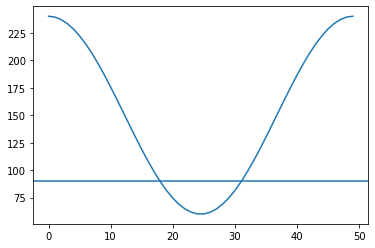

In [7]:
plt.plot(func_sza(elv_max=30))
plt.axhline(y=90)

In [ ]:
# %% [Functions]
def func_sza(t=np.linspace(0, 3600*24), elv_max=90):
    #t in s
    elv = elv_max - 90*((np.cos(2*np.pi/(3600*24) * t)) + 1)
    return 90-elv

# from numba import jit
# @jit(nopython = True, cache = True)
def path_z (z_top, z_t, sol_zen, nsteps):
    if sol_zen == 0:
        z_step = np.linspace(z_top, z_t, nsteps)
        step = (z_top - z_t)/nsteps
    elif sol_zen == 180:
        z_step = np.zeros(nsteps)
        step = 0
    else:     
        Re = 6375 #km (should be the same unit as z)
        sol_zen /= 180/np.pi
        B=np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
        S_top=np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

        Ret2=(Re + z_t)**2
        step=S_top/nsteps
        S_top_half= S_top - step/2
        z_step=[np.sqrt(Ret2 +(S_top_half - i*step)**2 -
                        2*(Re + z_t)*(S_top_half - 
                          i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps) ]
        z_step = np.array(z_step)
        
    #check the Earth's shadow
    index = np.argmax(z_step<0)
    if index>0:
        z_step

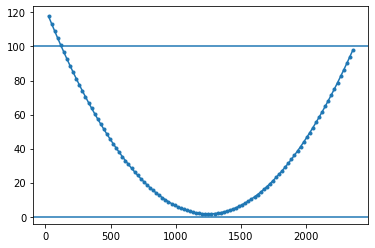

In [106]:
# %% [Functions]
def func_sza(t=np.linspace(0, 3600*24), elv_max=90):
    #t in s
    elv = elv_max - 90*((np.cos(2*np.pi/(3600*24) * t)) + 1)
    return 90-elv

# from numba import jit
# @jit(nopython = True, cache = True)
def path_z (z_top, z_t, sol_zen, nsteps):
    if sol_zen == 0:
        z_step = np.linspace(z_top, z_t, nsteps)
        step = (z_top - z_t)/nsteps
    elif sol_zen == 180:
        z_step = np.zeros(nsteps)
        step = 0
    else:     
        Re = 6375 #km (should be the same unit as z)
        sol_zen /= 180/np.pi
        B=np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
        S_top=np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

        Ret2=(Re + z_t)**2
        step=S_top/nsteps
        S_top_half= S_top - step/2
        z_step=[np.sqrt(Ret2 +(S_top_half - i*step)**2 -
                        2*(Re + z_t)*(S_top_half - 
                          i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps) ]
        z_step = np.array(z_step)
        
        #check the Earth's shadow
        if (z_step<0).any():
            z_step = np.zeros(nsteps)
#    index = np.argmax(z_step<0)
#    if index>0:
#        z_step[index-1:] = 0
    return(z_step, step)
    
z_t = 100
z_top = 120
sza = 100
z_paths, path_step = path_z(z_top, z_t, sza, 100)
plt.plot(np.linspace(1,100,100)*path_step, z_paths, label=sza, marker='.')
plt.axhline(y=z_t)
plt.axhline(y=0)

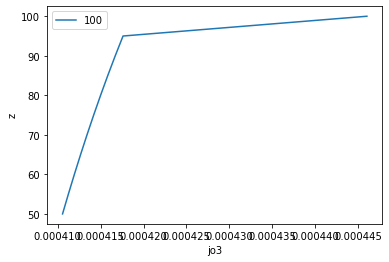

In [107]:
def photolysis(z, sol_zen, density_lst, xs_lst, name_lst):
    #z in km
    #density in cm-3
    #xs (cross section) in cm2
    #global variables: z, wavelength, irrad
    j_lst = [[] for i in range(len(density_lst))]
    # j_sum_lst = [[] for i in range(len(density_lst))]
    for iz, z_t in enumerate(z) :
        z_paths, path_step= path_z(z[-1], z_t, sol_zen, 100)
        attenuation_coeff = [xs * (np.exp(np.interp(z_paths, z, np.log(density)))).sum() #sum over z_paths
                               for xs, density in zip(xs_lst, density_lst)]
        tau = np.sum(attenuation_coeff, axis=0) * path_step *1e5 #km-->cm , sum over species   
        j_z_lst = (irrad * xs_lst * np.exp(-tau)) #
        [j.append(j_z) for j,j_z in zip(j_lst, j_z_lst)]
        # [j_sum.append(j_z.sum()) for j_sum,j_z in zip(j_sum_lst, j_z_lst)] #sum over wavelength
    
    data_j = {'j{}'.format(name): (('z', 'wavelength'), j) for name,j in zip(name_lst, j_lst)}
    # data_j_sum = {'j{}_sum'.format(name): (('z',), j_sum) for name,j_sum in zip(name_lst, j_sum_lst)}

    return xr.Dataset({'z': (('z',), z), 'wavelength': (('wavelength',), wavelength), **data_j})#, **data_j_sum})

# z = np.arange(50,100,5)
#sol_zen = 90
#ds = photolysis(z=z, sol_zen=sol_zen, 
#                  density_lst=(o2.density, o3.density, h2o.density, h2o2.density),
#                  xs_lst=(so2, so3, sh2o, sh2o2), name_lst=('o2', 'o3', 'h2o', 'h2o2'))

#ds.jo3.sum('wavelength').plot(y='z', label=sol_zen, xscale='log')

sol_zen = 100
ds = photolysis(z=z, sol_zen=sol_zen, 
                  density_lst=(o2.density, o3.density, h2o.density, h2o2.density),
                  xs_lst=(so2, so3, sh2o, sh2o2), name_lst=('o2', 'o3', 'h2o', 'h2o2'))

ds.jo3.sum('wavelength').plot(y='z', label=sol_zen)
plt.legend()

# ds.jo3.sel(wavelength=slice(200,730)).sum('wavelength').plot(y='z')
# ds.jo3.sel(wavelength=slice(167.5,320)).sum('wavelength').plot(y='z')

In [16]:
# set photolysis rates
def set_time_dependent_variables(t_s, elv_max=90):
    sol_zen = func_sza(t=t_s, elv_max=elv_max)
    if sol_zen<105: 
        print('cal and set J', 't={}s, {}h'.format(t_s%(24*3600), t_s*s2h%24), 'sza={}'.format(sol_zen))
        ds_j = photolysis(z=z, sol_zen=sol_zen, 
                        density_lst=(o2.density, o3.density, h2o2.density),
                        xs_lst=(so2, so3, sh2o2), 
                        name_lst=('o2', 'o3', 'h2o2'))
        next(r for r in reaction_lst if r.rate_constant.name=='J1'
            ).rate_constant.set_value(ds_j.jo2.sel(wavelength=slice(177.5, 256)).sum('wavelength'))
        next(r for r in reaction_lst if r.rate_constant.name=='J2'
            ).rate_constant.set_value(ds_j.jo2.sel(wavelength=slice(177.5)).sum('wavelength'))
        next(r for r in reaction_lst if r.rate_constant.name=='J3'
            ).rate_constant.set_value(ds_j.jo3.sel(wavelength=slice(200, 730)).sum('wavelength'))
        next(r for r in reaction_lst if r.rate_constant.name=='J4'
            ).rate_constant.set_value(ds_j.jo3.sel(wavelength=slice(167.5, 320)).sum('wavelength'))
    #     next(r for r in reaction_lst if r.rate_constant.name=='J5'
    #         ).rate_constant.set_value(ds_j.jh2o.sel(wavelength=slice(202.5)).sum('wavelength'))
    #     next(r for r in reaction_lst if r.rate_constant.name=='J6'
    #         ).rate_constant.set_value(ds_j.jh2o.sel(wavelength=slice(121.57)).sum('wavelength'))
        next(r for r in reaction_lst if r.rate_constant.name=='J7'
            ).rate_constant.set_value(ds_j.jh2o2.sel(wavelength=slice(122,350)).sum('wavelength'))
    else:
        print('zero J', 't={}s, {}h'.format(t_s%(24*3600), t_s*s2h%24), 'sza={}'.format(sol_zen))
        for n in [1,2,3,4,7]:
            next(r for r in reaction_lst if r.rate_constant.name=='J{}'.format(n)
                 ).rate_constant.set_value(xr.zeros_like(T))
        # [next(r for r in reaction_lst if r.rate_constant.name=='J{}'.format(n)
        #      ).rate_constant.set_value(xr.zeros_like(T)) for n in [1,2,3,4,7]]
        
def get_time_dependent_variables(t_s, elv_max=90):
    sol_zen = func_sza(t=t_s, elv_max=elv_max)
    if sol_zen<105: 
        print('t={}s'.format(t_s), 'sza={}'.format(sol_zen), 'cal J')
        ds_j = photolysis(z=z, sol_zen=sol_zen, 
                        density_lst=(o2.density, o3.density, h2o2.density),
                        xs_lst=(so2, so3, sh2o2), 
                        name_lst=('o2', 'o3', 'h2o2'))
        J1 = ds_j.jo2.sel(wavelength=slice(177.5, 256)).sum('wavelength').rename('J1') #Herzberg
        J2 = ds_j.jo2.sel(wavelength=slice(177.5)).sum('wavelength').rename('J2') #Schuman-Runge
        J3 = ds_j.jo3.sel(wavelength=slice(200, 730)).sum('wavelength').rename('J3') #Hartley + Huggins
        J4 = ds_j.jo3.sel(wavelength=slice(167.5, 320)).sum('wavelength').rename('J4') #Hartley
        J7 = ds_j.jh2o2.sel(wavelength=slice(122, 350)).sum('wavelength').rename('J7') 

    else:
        print('t={}s'.format(t_s), 'sza={}'.format(sol_zen), 'zero J')
        J1 = xr.DataArray(np.zeros(z.shape), dims=('z',), coords=(z, )).rename('J1')
        J2 = xr.DataArray(np.zeros(z.shape), dims=('z',), coords=(z, )).rename('J2')
        J3 = xr.DataArray(np.zeros(z.shape), dims=('z',), coords=(z, )).rename('J3')
        J4 = xr.DataArray(np.zeros(z.shape), dims=('z',), coords=(z, )).rename('J4')
        J7 = xr.DataArray(np.zeros(z.shape), dims=('z',), coords=(z, )).rename('J7')
    return xr.merge([J1, J2, J3, J4, J7])

In [110]:
# %% [Functions of the system equations]    
# calculate production rate of a query species in the system
def prod_rate(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #prod_sum is a np arry

    #find stoichiometric coefficients
    prod_stoichio_coeff = np.array([r.products.count(species_query) for r in reaction_lst])

    #calculate production rates
    prod_rates = [r.rate() * n
                  for r, n in zip(reaction_lst, prod_stoichio_coeff) if n>0]
    
    #sum up all the relavant production rates and losses
    prod_sum = np.sum([P for P in prod_rates], axis=0)
    return prod_sum

# calculate loss rate of a query species in the system
def loss_rate(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #loss_sum is a np array

    #find stoichiometric coefficients
    loss_stoichio_coeff = np.array([r.reactants.count(species_query) for r in reaction_lst])
    
    #calculate loss rates
    loss_rates = [r.rate() * n
                  for r, n in zip(reaction_lst, loss_stoichio_coeff) if n>0]
    
    #sum up all the relavant production rates and losses
    loss_sum = np.sum([L for L in loss_rates], axis=0)
    return loss_sum

# calculate the rate of change (dxdt) of a query species 
def continuity(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    # dxdt, prod_sum, loss_sum are np.array
    
    prod_sum = prod_rate(species_query, reaction_lst)
    loss_sum = loss_rate(species_query, reaction_lst)
    #continuity equation
    dxdt = prod_sum - loss_sum
    
    return dxdt, prod_sum, loss_sum

# calculate lifetime of a query species in the system
def lifetime_inverse(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #loss_sum (1/total lifetime) is np array
    #loss_sources is a dictionary with reaction names as keys and losses (array) as values
    
    #find stoichiometric coefficients
    loss_stoichio_coeff = np.array([r.reactants.count(species_query) for r in reaction_lst])
    
    #calculate relavant losses 
    loss_sources_1st_order = {}
    loss_sources_2nd_order = {}

    for r in reaction_lst:
        if loss_stoichio_coeff[reaction_lst.index(r)]==1:
            reactants_ex = [s for s in r.reactants if s!=species_query]
            L = r.rate_constant.value * np.prod([s.density for s in reactants_ex], axis=0)
            loss_sources_1st_order[r.name] = L

        elif loss_stoichio_coeff[reaction_lst.index(r)]==2:
            reactants_ex = [s for s in r.reactants if s!=species_query]
            L = 2 * r.rate_constant.value * np.prod([s.density for s in reactants_ex], axis=0)
            loss_sources_2nd_order[r.name] = L
            
        elif loss_stoichio_coeff[reaction_lst.index(r)]>2:
            ''' I dont know how to do higher order reaction yet '''
            print('higher order losses')
            pass
        
    #sum relavant losses
    loss_sum_1st_order = xr.Dataset(loss_sources_1st_order).to_array().sum('variable') 
    if loss_sources_2nd_order == {}:
        loss_sum_2nd_order = xr.zeros_like(loss_sum_1st_order)
    else:
        loss_sum_2nd_order = xr.Dataset(loss_sources_2nd_order).to_array().sum('variable') 
    return loss_sum_1st_order, loss_sum_2nd_order, loss_sources_1st_order, loss_sources_2nd_order

# calculate density of a query species assuming it is in equilibrium state
def equilibrium(species_query, reaction_lst):
    #species_query is an instance of class Species
    #reaction_lst is a list of reactions
    #density_query is a np array
        
    prod_sum = prod_rate(species_query, reaction_lst)
    loss_sum_1st_order, loss_sum_2nd_order, _, _ = lifetime_inverse(species_query, reaction_lst)
    if (loss_sum_2nd_order == 0).all():
        density_query = prod_sum/loss_sum_1st_order
    else:
        # print('2nd order polynomial solver')
        a = loss_sum_2nd_order
        b = loss_sum_1st_order
        c = -prod_sum
        density_query = (-b + np.sqrt(b**2 - 4 * a * c)) / 2/a
    return density_query

In [111]:
#cross sections
with xr.open_dataset('/home/anqil/Documents/Python/Photochemistry/xs_anqi.nc') as ds:
    wavelength = ds.wavelength.values
    so2 = ds.so2.values
    so3 = ds.so3.values
    sh2o = ds.sh2o.values
    sh2o2 = ds.sh2o2.values
    irrad = ds.irrad.values

In [112]:
# %% [Set up the system (species involved and list of reactions)]
n2 = Species(name='N2')
o2 = Species(name='O2')
o3 = Species(name='O3')
o = Species(name='O')
o1d = Species(name='O(1D)')
h2o = Species(name='H2O')
h = Species(name='H')
oh = Species(name='OH')
h2 = Species(name='H2')
h2o2 = Species(name='H2O2')
ho2 = Species(name='HO2')
m = Species(name='M')
ch4 = Species(name='CH4')
co = Species(name='CO')
species_lst = [n2, o2, o3, o, o1d, h2o, h, oh, h2, h2o2, ho2, m, ch4, co]

reaction_lst = [
    Reaction(reactants=(o2,), products=(o, o), name='R1'),
    Reaction(reactants=(o2,), products=(o, o1d), name='R2'),
    Reaction(reactants=(o3,), products=(o2, o), name='R3'),
    Reaction(reactants=(o3,), products=(o2, o1d), name='R4'),
#     Reaction(reactants=(h2o,), products=(h, oh), name='R5'), #remove 
#     Reaction(reactants=(h2o,), products=(h2, o1d), name='R6'), #remove
    Reaction(reactants=(h2o2,), products=(oh, oh), name='R7'),
    Reaction(reactants=(o1d, o2), products=(o, o2), name='R8'),
    Reaction(reactants=(o1d, n2), products=(o, n2), name='R9'),
    Reaction(reactants=(o1d, h2o), products=(oh, oh), name='R10'),
    Reaction(reactants=(o1d, h2), products=(h, oh), name='R11'),
    Reaction(reactants=(o, o, m), products=(o2, m), name='R12'),
    Reaction(reactants=(o, o2, o), products=(o3, o), name='R13'),
    Reaction(reactants=(o, o2, o2), products=(o3, o2), name='R14'),
    Reaction(reactants=(o, o2, n2), products=(o3, n2), name='R15'),
    Reaction(reactants=(o, o3), products=(o2, o2), name='R16'),
    Reaction(reactants=(o, oh), products=(o2, h), name='R17'),
    Reaction(reactants=(o, ho2), products=(oh, o2), name='R18'),
    Reaction(reactants=(o, h2o2), products=(oh, ho2), name='R19'),
    Reaction(reactants=(o, h2), products=(oh, h), name='R20'),
    Reaction(reactants=(oh, o3), products=(ho2, o2), name='R21'),
    Reaction(reactants=(oh, oh), products=(h2o, o), name='R22'),
    Reaction(reactants=(oh, ho2), products=(h2o, o2), name='R23'),
    Reaction(reactants=(oh, h2o2), products=(h2o, ho2), name='R24'),
    Reaction(reactants=(oh, h2), products=(h2o, h), name='R25'),
    Reaction(reactants=(ho2, o3), products=(oh, o2, o2), name='R26'),
    Reaction(reactants=(ho2, ho2), products=(h2o2, o2), name='R27'),
    Reaction(reactants=(h, o2, m), products=(ho2, m), name='R28'),
    Reaction(reactants=(h, o3), products=(oh, o2), name='R29'),
    Reaction(reactants=(h, ho2), products=(h2, o2), name='R30'),
    Reaction(reactants=(h, ho2), products=(oh, oh), name='R31'),
    Reaction(reactants=(h, ho2), products=(h2o, o), name='R32'),
    Reaction(reactants=(h, h, m), products=(h2, m), name='R33'),
        # r34 
    Reaction(reactants=(ch4, oh), products=(co, oh, h2o, h2o), name='R35'),
    Reaction(reactants=(ch4, o), products=(co, oh, oh, h2o), name='R36'),
    Reaction(reactants=(ch4, o1d), products=(co, oh, oh, h2o), name='R37')]


In [113]:
# %% [Set up the known densities and rate conctants]
with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
    z = np.arange(50, 105, 5)
    T = ds.T.interp(z=z)
    m.set_density(ds.m.interp(z=z)).set_unit('cm-3')
    o2.set_density(m.density*0.2).set_unit('cm-3')
    n2.set_density(m.density*0.8).set_unit('cm-3')
    h2.set_density(ds.h2.interp(z=z)).set_unit('cm-3')
    h2o.set_density(ds.h2o.interp(z=z)).set_unit('cm-3')
    ch4.set_density(ds.ch4.interp(z=z)).set_unit('cm-3')
    co.set_density(ds.co.interp(z=z)).set_unit('cm-3')

rate_const_lst = [
    RateConstant(name='J1', unit='s-1', reaction_name='R1'), 
    RateConstant(name='J2', unit='s-1', reaction_name='R2'), 
    RateConstant(name='J3', unit='s-1', reaction_name='R3'), 
    RateConstant(name='J4', unit='s-1', reaction_name='R4'), 
    RateConstant(name='J5', unit='s-1', reaction_name='R5'), 
    RateConstant(name='J6', unit='s-1', reaction_name='R6'), 
    RateConstant(name='J7', unit='s-1', reaction_name='R7'),
    RateConstant(value=3.2e-11*np.exp(117/T), name='k8', unit='cm3s-1', reaction_name='R8'),
    RateConstant(value=1.8e-11*np.exp(157/T), name='k9', unit='cm3s-1', reaction_name='R9'),
    RateConstant(value=2.3e-10*np.exp(-100/T), name='k10', unit='cm3s-1', reaction_name='R10'),
    RateConstant(value=1.1e-10*xr.ones_like(T), name='k11', unit='cm3s-1', reaction_name='R11'),
    RateConstant(value=9.59e-34*np.exp(480/T), name='k12', unit='cm6s-1', reaction_name='R12'),
    RateConstant(value=2.15e-34*np.exp(-345/T), name='k13', unit='cm6s-1', reaction_name='R13'),
    RateConstant(value=2.15e-34*np.exp(-345/T), name='k14', unit='cm6s-1', reaction_name='R14'),
    RateConstant(value=8.82e-35*np.exp(-575/T), name='k15', unit='cm6s-1', reaction_name='R15'),
    RateConstant(value=1.5e-11*np.exp(-2218/T), name='k16', unit='cm3s-1', reaction_name='R16'),
    RateConstant(value=2.3e-11*np.exp(-90/T), name='k17', unit='cm3s-1', reaction_name='R17'),
    RateConstant(value=2.8e-11*np.exp(172/T), name='k18', unit='cm3s-1', reaction_name='R18'),
    RateConstant(value=1.0e-11*np.exp(-2500/T), name='k19', unit='cm3s-1', reaction_name='R19'),
    RateConstant(value=1.6e-11*np.exp(-4570/T), name='k20', unit='cm3s-1', reaction_name='R20'),
    RateConstant(value=1.6e-12*np.exp(-940/T), name='k21', unit='cm3s-1', reaction_name='R21'),
    RateConstant(value=4.5e-12*np.exp(-275/T), name='k22', unit='cm3s-1', reaction_name='R22'),
    RateConstant(value=8.4e-11*xr.ones_like(T), name='k23', unit='cm3s-1', reaction_name='R23'),
    RateConstant(value=2.9e-12*np.exp(-160/T), name='k24', unit='cm3s-1', reaction_name='R24'),
    RateConstant(value=7.7e-12*np.exp(-2100/T), name='k25', unit='cm3s-1', reaction_name='R25'),
    RateConstant(value=1.4e-14*np.exp(-580/T), name='k26', unit='cm3s-1', reaction_name='R26'),
    RateConstant(value=2.4e-14*np.exp(1250/T), name='k27', unit='cm3s-1', reaction_name='R27'),
    RateConstant(value=1.76e-28*T**(-1.4), name='k28', unit='cm6s-1', reaction_name='R28'),
    RateConstant(value=1.4e-10*np.exp(-270/T), name='k29', unit='cm3s-1', reaction_name='R29'),
    RateConstant(value=6.0e-12*xr.ones_like(T), name='k30', unit='cm3s-1', reaction_name='R30'),
    RateConstant(value=7.0e-11*xr.ones_like(T), name='k31', unit='cm3s-1', reaction_name='R31'),
    RateConstant(value=2.3e-12*xr.ones_like(T), name='k32', unit='cm3s-1', reaction_name='R32'),
    RateConstant(value=1.0e-30*T**(-0.8), name='k33', unit='cm6s-1', reaction_name='R33'),
    #       RateConstant(value=6.0e-12, name='k34'),
    RateConstant(value=2.4e-12*np.exp(-1710/T), name='k35', unit='cm3s-1', reaction_name='R35'),
    RateConstant(value=3.5e-11*np.exp(-4550/T), name='k36', unit='cm3s-1', reaction_name='R36'),
    RateConstant(value=1.4e-10*xr.ones_like(T), name='k37', unit='cm3s-1', reaction_name='R37')]

#set rate constant to each reaction
reaction_lst = [r.set_rate_constant(next(k for k in rate_const_lst if k.reaction_name==r.name)
                                   ) for r in reaction_lst]


cal and set J t=54000s, 15.0h sza=26.360389693210706


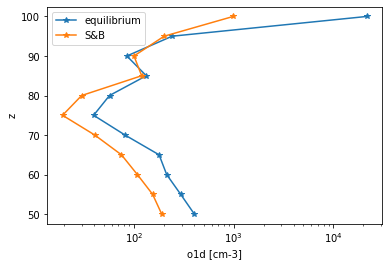

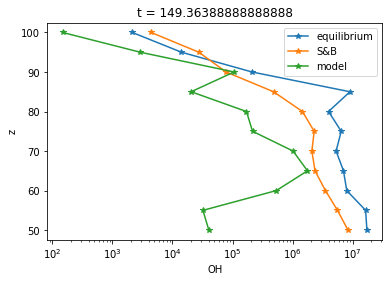

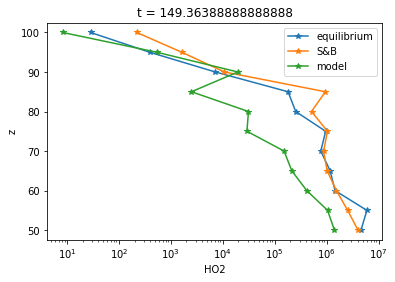

In [128]:
# %% [test one species and see if an error occurrs]
o3.remove_density()
o.remove_density()
o1d.remove_density()
h.remove_density()
oh.remove_density()
ho2.remove_density()
h2o2.remove_density()
[next(r for r in reaction_lst if r.rate_constant.name=='J{}'.format(n)
     ).rate_constant.set_value(None) for n in [1,2,3,4,7]]

#set densities 
with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
    [s.set_density(ds[s.name.lower()].interp(z=z)).set_unit('cm-3')
     for s in (o3, o, h, h2o2, oh,  ho2)] 

#setphotolysis rates
lst = 15 #hour
set_time_dependent_variables(t_s=lst*h2s)

#set equilibrium species densities
o1d = o1d.set_density(equilibrium(o1d, reaction_lst))
oh = oh.set_density(equilibrium(oh, reaction_lst))
ho2 = ho2.set_density(equilibrium(ho2, reaction_lst))

plt.figure()
o1d.density.plot(y='z', marker='*', xscale='log', label='equilibrium')
with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
    ds.o1d.sel(z=slice(50,100)).plot(y='z',xscale='log', marker='*', label='S&B')
plt.legend()

plt.figure()
oh.density.plot(y='z', marker='*', xscale='log', label='equilibrium')
with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
    ds.oh.sel(z=slice(50,100)).plot(y='z',xscale='log', marker='*', label='S&B')
with xr.open_dataset('./ode_result_{}_{}_{}.nc'.format(127, 149, 20)) as ds:
    ds.OH.isel(t=-1).plot(y='z', xscale='log', marker='*', label='model')
plt.legend()

plt.figure()
ho2.density.plot(y='z', marker='*', xscale='log', label='equilibrium')
with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
    ds.ho2.sel(z=slice(50,100)).plot(y='z',xscale='log', marker='*', label='S&B')
with xr.open_dataset('./ode_result_{}_{}_{}.nc'.format(127, 149, 20)) as ds:
    ds.HO2.isel(t=-1).plot(y='z', xscale='log', marker='*', label='model')
plt.legend()

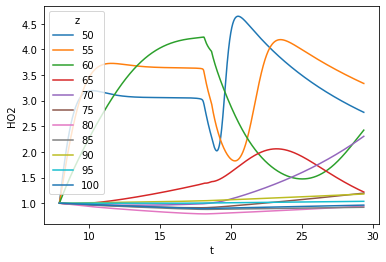

In [140]:
with xr.open_dataset('./ode_result_{}_{}_{}.nc'.format(127, 149, 20)) as ds:
    ds = ds.assign(t=ds.t-24*5)
    ds.HO2.pipe(lambda x: x/x.isel(t=0)).plot(x='t', hue='z', yscale='linear')

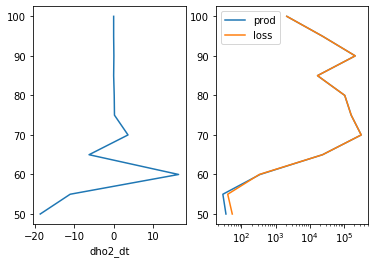

In [122]:
#set densities 
# with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
#     [s.set_density(ds[s.name.lower()].interp(z=z)) for s in (o3, o, h, h2o2, oh,  ho2)] 
with xr.open_dataset('./ode_result_{}_{}_{}.nc'.format(127, 149, 20)) as ds:
    [s.set_density(ds[s.name].isel(t=-1).interp(z=z)) for s in (o3, o, h, h2o2, oh,  ho2)]
#calculate query species density rate of change 
dho2_dt, ho2_prod, ho2_loss = continuity(ho2, reaction_lst)

plt.figure()
plt.subplot(121)
plt.plot(dho2_dt, z)
plt.xlabel('dho2_dt')
plt.subplot(122)
plt.plot(ho2_prod, z, label='prod')
plt.plot(ho2_loss, z, label='loss')
plt.gca().set(xscale='log')
plt.legend()

In [124]:
# %%[ Integration ]
def balance(species_query_densities, t_s, 
            species_query, reaction_lst, species_equilibrium, elv_max=90):
    #t_s in second
    #species_query_densities is a flatten array of profiles of all query species
    #species_query is a list/tuple of instances of class Species
    #reaction_lst is a list of Reactions
    #species_equilibrium is a list of species that is assumed to be in equilibrium state
    
    #set query species desity
    species_query_density_lst = species_query_densities.reshape(len(species_query), len(z))
    for s in species_query:
        s.set_density(species_query_density_lst[species_query.index(s)])

    #set time dependent photolysis rates
    set_time_dependent_variables(t_s, elv_max=elv_max)
        
    #set equilibrium species densities
    for s in species_equilibrium:
        s.set_density(equilibrium(s, reaction_lst))

    #calculate query species density rate of change
    dxdt = []
    for s in species_query:
        dxdt.append(continuity(s, reaction_lst)[0])
        
    return np.ravel(dxdt)

In [125]:
# %%
# calibrate stuff that might have left from the previous tests
o3.remove_density()
o.remove_density()
o1d.remove_density()
h.remove_density()
oh.remove_density()
ho2.remove_density()
h2o2.remove_density()
[next(r for r in reaction_lst if r.rate_constant.name=='J{}'.format(n)
     ).rate_constant.set_value(None) for n in [1,2,3,4,7]]


In [126]:
#%% start from s&b
# %%time
# #set densities 
# with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
#     [s.set_density(ds[s.name.lower()].interp(z=z)).set_unit('cm-3')
#      for s in (o3, o, h, h2o2, oh,  ho2)] 

# # # set lists of species
# species_query = [o3, o, h, h2o2]
# species_equilibrium = [o1d, ho2, oh]
# t_start = h2s * 15 #s
# t_end = h2s * 15.1 #s
# dt = 50 #s
# #set starting densities 
# with xr.open_dataset('./s&b_tables_anqi.nc') as ds:
#     x0 = [ds[s.name.lower()].interp(z=z) for s in species_query]
# x0 = np.ravel(x0)
# t = np.arange(t_start, t_end, dt)
# x = odeint(balance, x0, t, 
#            args=(species_query, reaction_lst, species_equilibrium, 90))
# x = x.reshape(len(t), len(species_query), len(z))

# data_lst = [xr.DataArray(x[:,i,:], coords=(t, z), dims=('t', 'z')) for i in range(len(species_query))]
# ode_result = xr.Dataset({s.name: data for s, data in zip(species_query, data_lst) })
# ode_result = ode_result.assign(t=ode_result.t*s2h)
# ode_result = ode_result.update({s.name: s.density for s in [m, h2o, h2]})
# # # ode_result.to_netcdf('./ode_result_{}_{}_{}.nc'.format(int(t_start*s2h), int(t_end*s2h), dt))


In [129]:
# %% start from last model run
# %%time
#set lists of species
species_query = [o3, o, h, h2o2, oh, ho2]
species_equilibrium = [o1d]

#set new starting densities 
with xr.open_dataset('./ode_result_{}_{}_{}.nc'.format(149, 179, 50)) as ds:
    # ds = ds.assign({'H': ds.H*2}) #test
    ds = ds.where(ds.O3!=0, drop=True) #remove 0 values from the earlier run
    t_start_new = ds.t[-1].values * h2s
    x0 = [ds[s.name].isel(t=-1).interp(z=z) for s in species_query]
    # [s.set_density(ds[s.name].isel(t=-1).interp(z=z)).set_unit('cm-3') for s in (o3, o, h, oh,  ho2, h2o2)]

x0 = np.ravel(x0)
t_end_new = t_start_new + 0.1*h2s
dt = 50
t = np.arange(t_start_new, t_end_new, dt)
# plt.plot(t*s2h, func_sza(t))

x = odeint(balance, x0, t, 
           args=(species_query, reaction_lst, species_equilibrium, 90),
           printmessg=True)
x = x.reshape(len(t), len(species_query), len(z))
data_lst = [xr.DataArray(x[:,i,:], coords=(t, z), dims=('t', 'z')) for i in range(len(species_query))]
ode_result = xr.Dataset({s.name: data for s, data in zip(species_query, data_lst) })
ode_result = ode_result.assign(t=ode_result.t*s2h)
# ode_result.to_netcdf('./ode_result_{}_{}_{}.nc'.format(int(t_start_new*s2h), int(t_end_new*s2h), dt))


cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.0s, 5.36388888888888h sza=104.91883283559946
cal and set J t=19310.000000000116s, 5.3638888888889085h sza=104.9188328355982
cal and set J t=19310.000000000116s, 5.3638888888889085h sza=104.9188328355982
cal and set J t=19310.000000000233s, 5.363888888888965h sza=104.91883283559757
cal and set J t=19310.0000

KeyboardInterrupt: 